In [82]:
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models


In [83]:
def display_images(image_paths, title, max_images=4):
    plt.figure(figsize=(12, 3))
    for i, path in enumerate(image_paths[:max_images]):
        img = plt.imread(path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()




In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Train santa 이미지 개수: 446


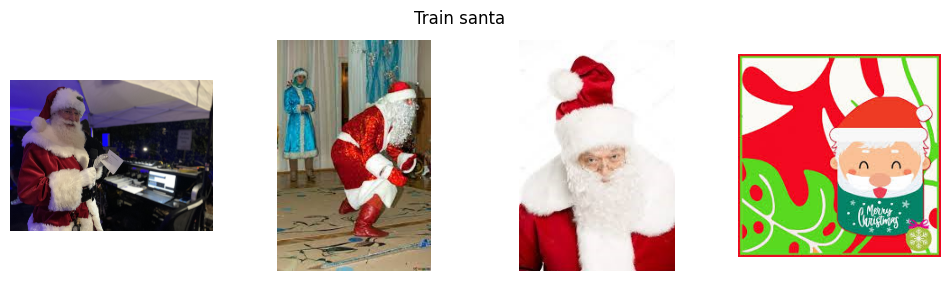

Train normal 이미지 개수: 449


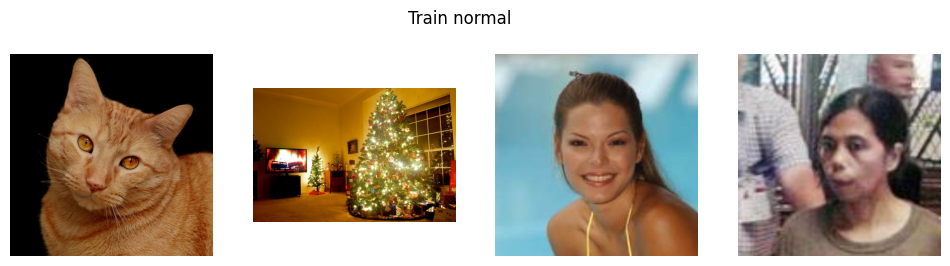

Val santa 이미지 개수: 133


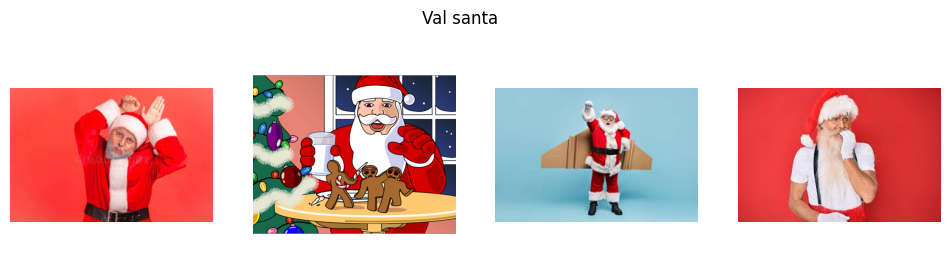

Val normal 이미지 개수: 134


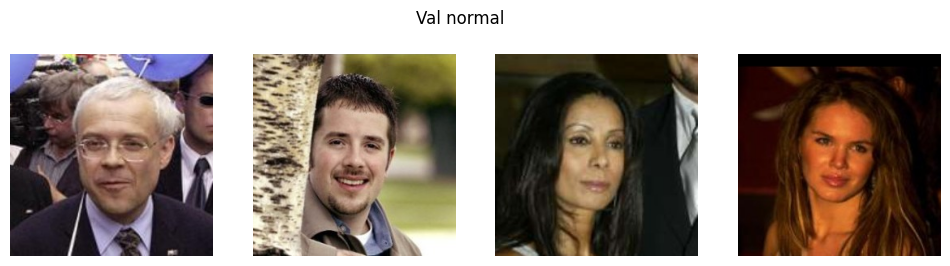

Test santa 이미지 개수: 36


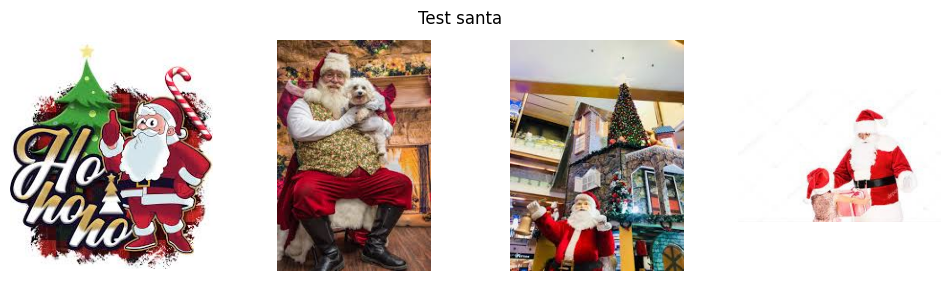

Test normal 이미지 개수: 32


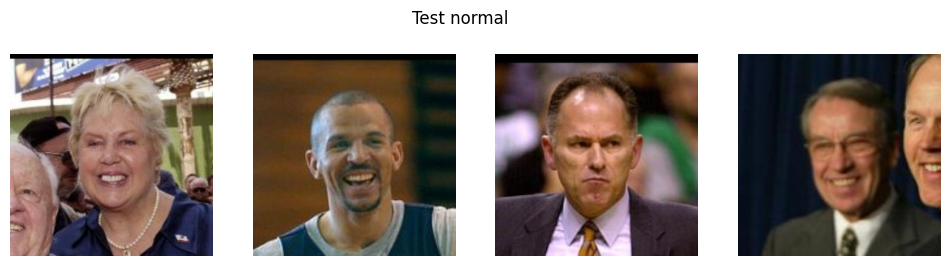

In [85]:
categories = ['Train santa', 'Train normal', 'Val santa', 'Val normal', 'Test santa', 'Test normal']

for category in categories:
    image_paths = glob.glob(f'../실습 파일/4/{category.lower().replace(" ", "/")}/*')
    print(f'{category} 이미지 개수: {len(image_paths)}')
    display_images(image_paths, category)






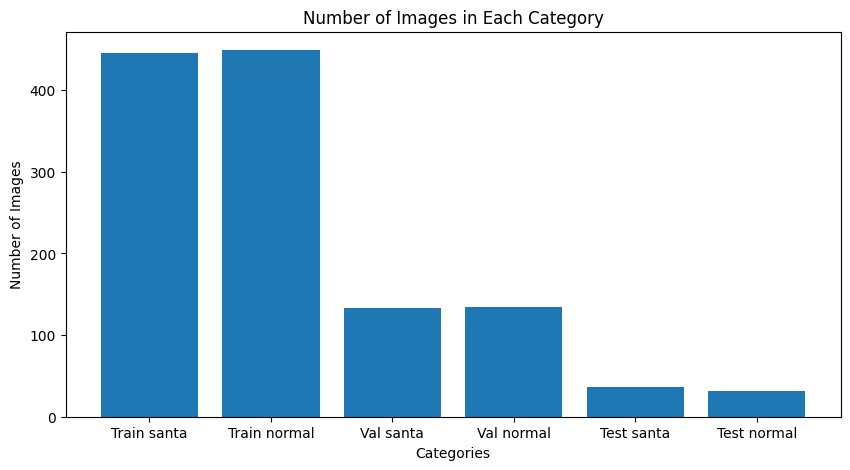

In [86]:
# 바 그래프 생성

plt.figure(figsize=(10, 5))
plt.bar(categories, [len(glob.glob(f'../실습 파일/4/{category.lower().replace(" ", "/")}/*')) for category in categories])
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Category')
plt.show()



In [87]:
# 데이터 augmentation

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [88]:
train_path = '../실습 파일/4/train'
val_path = '../실습 파일/4/val'
test_path = '../실습 파일/4/test'

train_dataset = ImageFolder(train_path, transform=transform)
val_dataset = ImageFolder(val_path, transform=transform)
test_dataset = ImageFolder(test_path, transform=transform)


In [89]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)



In [90]:
class VGG19(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG19, self).__init__()
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes), #기존 논문에서는 1000개의 클래스 분류 문제
            # 시그모이드 활성화 함수는 nn.BCEWithLogitsLoss에 포함
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [91]:

# 사전 학습된 vgg19 모델 불러오기
pretrained_vgg19 = models.vgg19(pretrained=True)
pretrained_vgg19 = pretrained_vgg19.to(device)

# 새로 정의한 모델 인스턴스 생성성
net = VGG19(num_classes=1000)
net = net.to(device)
# 사전 학습된 모델의 features부분에서 가중치 추출
pretrained_keys = set(pretrained_vgg19.features.state_dict().keys())

result = net.features.load_state_dict(pretrained_vgg19.features.state_dict(), strict=False)

custum_keys = set(net.features.state_dict().keys())

successfully_copied_keys = pretrained_keys.intersection(custum_keys)
missing_keys = pretrained_keys - custum_keys
unexpected_keys = custum_keys - pretrained_keys

print(f"Successfully copied keys: {len(successfully_copied_keys)}, {successfully_copied_keys}")
print(f"Missing keys: {len(missing_keys)}, {result.missing_keys}")
print(f"Unexpected keys: {len(unexpected_keys)}, {result.unexpected_keys}")


c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Successfully copied keys: 32, {'7.bias', '32.bias', '19.weight', '30.bias', '21.weight', '23.weight', '2.weight', '12.weight', '12.bias', '5.weight', '30.weight', '25.bias', '10.bias', '28.weight', '0.bias', '19.bias', '5.bias', '16.bias', '21.bias', '28.bias', '2.bias', '14.bias', '34.bias', '34.weight', '23.bias', '10.weight', '7.weight', '14.weight', '16.weight', '25.weight', '32.weight', '0.weight'}
Missing keys: 0, []
Unexpected keys: 0, []


In [92]:
# 모델의 모든 파라미터 고정
for param in net.features.parameters():
    param.requires_grad = False


In [93]:
# classifier 부분의 가중치는 학습을 위해 새로 정의

net.classifier[6] = nn.Linear(4096, 1)
net.classifier[6].requires_grad = True
net.classifier[6] = net.classifier[6].to(device)  # 새로운 분류기 층도 GPU로 이동

for param in net.classifier.parameters():
    param.requires_grad = True


print(net)


VGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [94]:
# 손실함수 정의 -> BCEWithLogitsLoss : 이미 softmax 함수가 포함되어 있음
criterion = nn.BCEWithLogitsLoss()


In [95]:
def validate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.float().unsqueeze(1)  # 여기에 추가
            
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total

    return val_loss, val_accuracy

In [96]:
# import torch.optim as optim

# def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):
#     if optimizer_name == 'SGD':
#         optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#     elif optimizer_name == 'Adam':
#         optimizer = optim.Adam(net.parameters(), lr=0.0001)
#     elif optimizer_name == 'RAdam':
#         optimizer = optim.RAdam(net.parameters(), lr=0.0001)
#     elif optimizer_name == 'AdamW':
#         optimizer = optim.AdamW(net.parameters(), lr=0.0001)
#     else:
#         raise ValueError(f"Invalid optimizer: {optimizer_name}")
#     criterion = criterion.to(device)

#     train_losses = []
#     train_accuracies = []
#     val_losses = []
#     val_accuracies = []

#     for epoch in range(num_epochs):
#         net.train()
#         running_loss = 0.0
#         correct = 0
#         total = 0
#         for inputs, labels in train_loader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)
#             labels = labels.float().unsqueeze(1)  # 여기에 추가
            
#             optimizer.zero_grad()
#             outputs = net(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             running_loss += loss.item()
            
#         train_loss = running_loss / len(train_loader)
#         train_losses.append(train_loss)
        
#         val_loss, val_accuracy = validate_model(net, val_loader, criterion)
#         val_losses.append(val_loss)
#         val_accuracies.append(val_accuracy)

#         print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses:.4f}, Train Accuracy: {train_accuracies:.2f}%, Val Loss: {val_losses:.4f}, Val Accuracy: {val_accuracies:.2f}%")
        
#     return train_losses, train_accuracies, val_losses, val_accuracies
        
        
        


In [97]:
def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.0001)
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.0001)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(net.parameters(), lr=0.0001)
    else:
        raise ValueError(f"Invalid optimizer: {optimizer_name}")
    criterion = criterion.to(device)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.float().unsqueeze(1)  # 여기에 추가
            
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            predicted = (outputs > 0.5).float()  # BCE loss를 사용할 때의 예측 방식
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        val_loss, val_accuracy = validate_model(net, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%")
        
    return train_losses, train_accuracies, val_losses, val_accuracies

In [98]:
train_losses_SGD, train_accuracies_SGD, val_losses_SGD, val_accuracies_SGD = train_model('SGD', net, train_loader, val_loader, criterion)



Epoch 1/20, Train Loss: 0.5712, Train Accuracy: 62.01%, Val Loss: 0.3659, Val Accuracy: 89.51%
Epoch 2/20, Train Loss: 0.2891, Train Accuracy: 92.29%, Val Loss: 0.2045, Val Accuracy: 91.76%
Epoch 3/20, Train Loss: 0.2073, Train Accuracy: 92.29%, Val Loss: 0.1815, Val Accuracy: 92.88%
Epoch 4/20, Train Loss: 0.1568, Train Accuracy: 94.64%, Val Loss: 0.1664, Val Accuracy: 92.51%
Epoch 5/20, Train Loss: 0.1244, Train Accuracy: 95.98%, Val Loss: 0.1113, Val Accuracy: 94.38%
Epoch 6/20, Train Loss: 0.1087, Train Accuracy: 95.42%, Val Loss: 0.1020, Val Accuracy: 95.13%
Epoch 7/20, Train Loss: 0.0850, Train Accuracy: 97.54%, Val Loss: 0.1164, Val Accuracy: 95.51%
Epoch 8/20, Train Loss: 0.0689, Train Accuracy: 97.54%, Val Loss: 0.1062, Val Accuracy: 94.76%
Epoch 9/20, Train Loss: 0.0634, Train Accuracy: 97.77%, Val Loss: 0.1073, Val Accuracy: 96.25%
Epoch 10/20, Train Loss: 0.0456, Train Accuracy: 98.77%, Val Loss: 0.0879, Val Accuracy: 96.25%
Epoch 11/20, Train Loss: 0.0393, Train Accuracy: 

In [101]:
net = models.vgg19(pretrained=True)
net = net.to(device)  # GPU로 이동

for param in net.parameters():
    param.requires_grad = False

net.classifier[6] = nn.Linear(4096, 1)
net.classifier[6].requires_grad = True
net.classifier[6] = net.classifier[6].to(device)  # 새로운 분류기 층도 GPU로 이동

In [102]:
train_losses_Adam, train_accuracies_Adam, val_losses_Adam, val_accuracies_Adam = train_model('Adam', net, train_loader, val_loader, criterion)


Epoch 1/20, Train Loss: 0.5936, Train Accuracy: 66.93%, Val Loss: 0.4758, Val Accuracy: 89.51%
Epoch 2/20, Train Loss: 0.4197, Train Accuracy: 81.01%, Val Loss: 0.3639, Val Accuracy: 89.89%
Epoch 3/20, Train Loss: 0.3507, Train Accuracy: 87.49%, Val Loss: 0.3147, Val Accuracy: 91.76%
Epoch 4/20, Train Loss: 0.2978, Train Accuracy: 89.50%, Val Loss: 0.2741, Val Accuracy: 90.26%
Epoch 5/20, Train Loss: 0.2721, Train Accuracy: 90.39%, Val Loss: 0.2514, Val Accuracy: 92.51%
Epoch 6/20, Train Loss: 0.2510, Train Accuracy: 90.28%, Val Loss: 0.2342, Val Accuracy: 94.01%
Epoch 7/20, Train Loss: 0.2386, Train Accuracy: 91.28%, Val Loss: 0.2287, Val Accuracy: 91.01%
Epoch 8/20, Train Loss: 0.2390, Train Accuracy: 90.95%, Val Loss: 0.2187, Val Accuracy: 91.76%
Epoch 9/20, Train Loss: 0.2269, Train Accuracy: 89.61%, Val Loss: 0.2190, Val Accuracy: 92.88%
Epoch 10/20, Train Loss: 0.2162, Train Accuracy: 92.85%, Val Loss: 0.2009, Val Accuracy: 93.26%
Epoch 11/20, Train Loss: 0.2128, Train Accuracy: 

In [103]:
net = models.vgg19(pretrained=True)
net = net.to(device)  # GPU로 이동

for param in net.parameters():
    param.requires_grad = False

net.classifier[6] = nn.Linear(4096, 1)
net.classifier[6].requires_grad = True
net.classifier[6] = net.classifier[6].to(device)  # 새로운 분류기 층도 GPU로 이동

In [104]:
train_losses_RAdam, train_accuracies_RAdam, val_losses_RAdam, val_accuracies_RAdam = train_model('RAdam', net, train_loader, val_loader, criterion)


Epoch 1/20, Train Loss: 0.7296, Train Accuracy: 51.51%, Val Loss: 0.6842, Val Accuracy: 59.55%
Epoch 2/20, Train Loss: 0.6809, Train Accuracy: 52.51%, Val Loss: 0.6480, Val Accuracy: 68.16%
Epoch 3/20, Train Loss: 0.6311, Train Accuracy: 57.43%, Val Loss: 0.6072, Val Accuracy: 78.28%
Epoch 4/20, Train Loss: 0.5982, Train Accuracy: 60.11%, Val Loss: 0.5643, Val Accuracy: 84.64%
Epoch 5/20, Train Loss: 0.5484, Train Accuracy: 66.70%, Val Loss: 0.5161, Val Accuracy: 88.39%
Epoch 6/20, Train Loss: 0.5065, Train Accuracy: 71.84%, Val Loss: 0.4819, Val Accuracy: 88.39%
Epoch 7/20, Train Loss: 0.4743, Train Accuracy: 75.98%, Val Loss: 0.4422, Val Accuracy: 88.39%
Epoch 8/20, Train Loss: 0.4278, Train Accuracy: 80.22%, Val Loss: 0.4181, Val Accuracy: 87.27%
Epoch 9/20, Train Loss: 0.4082, Train Accuracy: 81.56%, Val Loss: 0.3806, Val Accuracy: 89.51%
Epoch 10/20, Train Loss: 0.3848, Train Accuracy: 84.80%, Val Loss: 0.3652, Val Accuracy: 89.51%
Epoch 11/20, Train Loss: 0.3589, Train Accuracy: 

In [105]:
net = models.vgg19(pretrained=True)
net = net.to(device)  # GPU로 이동

for param in net.parameters():
    param.requires_grad = False

net.classifier[6] = nn.Linear(4096, 1)
net.classifier[6].requires_grad = True
net.classifier[6] = net.classifier[6].to(device)  # 새로운 분류기 층도 GPU로 이동

In [106]:
train_losses_AdamW, train_accuracies_AdamW, val_losses_AdamW, val_accuracies_AdamW = train_model('AdamW', net, train_loader, val_loader, criterion)




Epoch 1/20, Train Loss: 0.5812, Train Accuracy: 67.60%, Val Loss: 0.4690, Val Accuracy: 87.64%
Epoch 2/20, Train Loss: 0.4301, Train Accuracy: 80.78%, Val Loss: 0.3660, Val Accuracy: 89.51%
Epoch 3/20, Train Loss: 0.3432, Train Accuracy: 86.93%, Val Loss: 0.3047, Val Accuracy: 90.64%
Epoch 4/20, Train Loss: 0.3047, Train Accuracy: 89.94%, Val Loss: 0.2719, Val Accuracy: 91.01%
Epoch 5/20, Train Loss: 0.2734, Train Accuracy: 91.17%, Val Loss: 0.2650, Val Accuracy: 91.39%
Epoch 6/20, Train Loss: 0.2564, Train Accuracy: 89.39%, Val Loss: 0.2418, Val Accuracy: 91.01%
Epoch 7/20, Train Loss: 0.2424, Train Accuracy: 91.84%, Val Loss: 0.2362, Val Accuracy: 90.64%
Epoch 8/20, Train Loss: 0.2375, Train Accuracy: 91.17%, Val Loss: 0.2340, Val Accuracy: 91.39%
Epoch 9/20, Train Loss: 0.2204, Train Accuracy: 93.18%, Val Loss: 0.2069, Val Accuracy: 92.88%
Epoch 10/20, Train Loss: 0.2267, Train Accuracy: 91.28%, Val Loss: 0.2002, Val Accuracy: 92.51%
Epoch 11/20, Train Loss: 0.2017, Train Accuracy: 

In [107]:
net = models.vgg19(pretrained=True)
net = net.to(device)  # GPU로 이동

for param in net.parameters():
    param.requires_grad = False

net.classifier[6] = nn.Linear(4096, 1)
net.classifier[6].requires_grad = True
net.classifier[6] = net.classifier[6].to(device)  # 새로운 분류기 층도 GPU로 이동

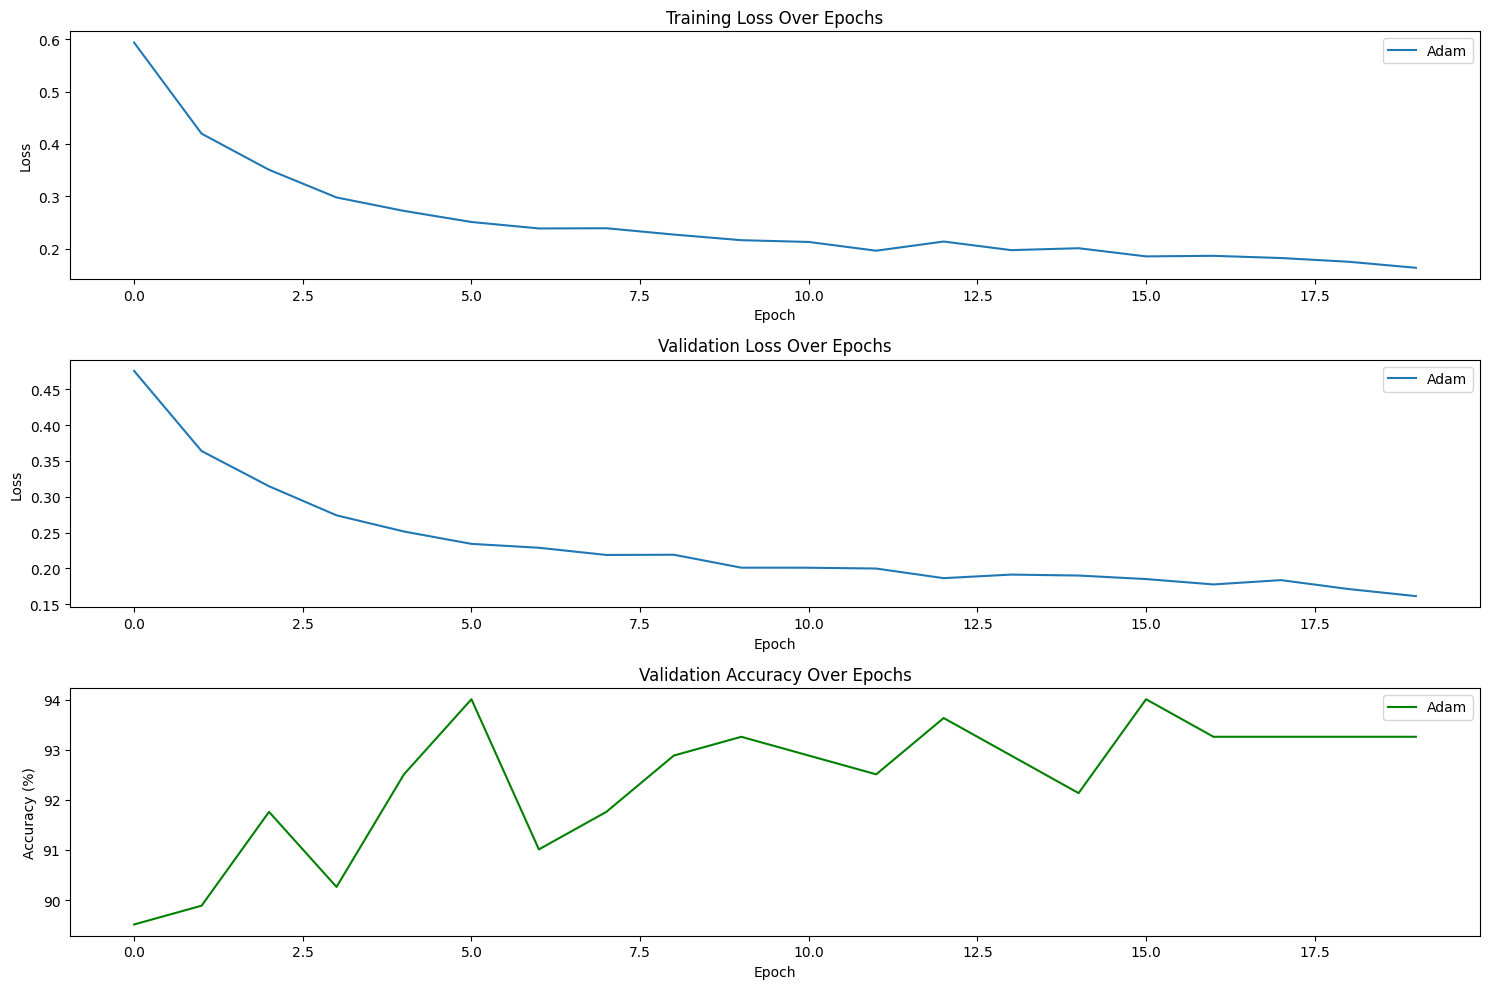

In [108]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_Adam, label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
# plt.ylim(0, 0.2)

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_Adam, label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
# plt.ylim(0, 1.5)

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_Adam, label='Adam', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
# plt.ylim(80, 100)

plt.tight_layout()
plt.show()

In [109]:
# Image load 및 tensor 변환
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    return image.to(device)  # GPU로 이동

In [112]:
def denormalize(tensor):
    # ImageNet 정규화에 사용된 평균과 표준편차
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    # 정규화 역변환
    return tensor * std + mean

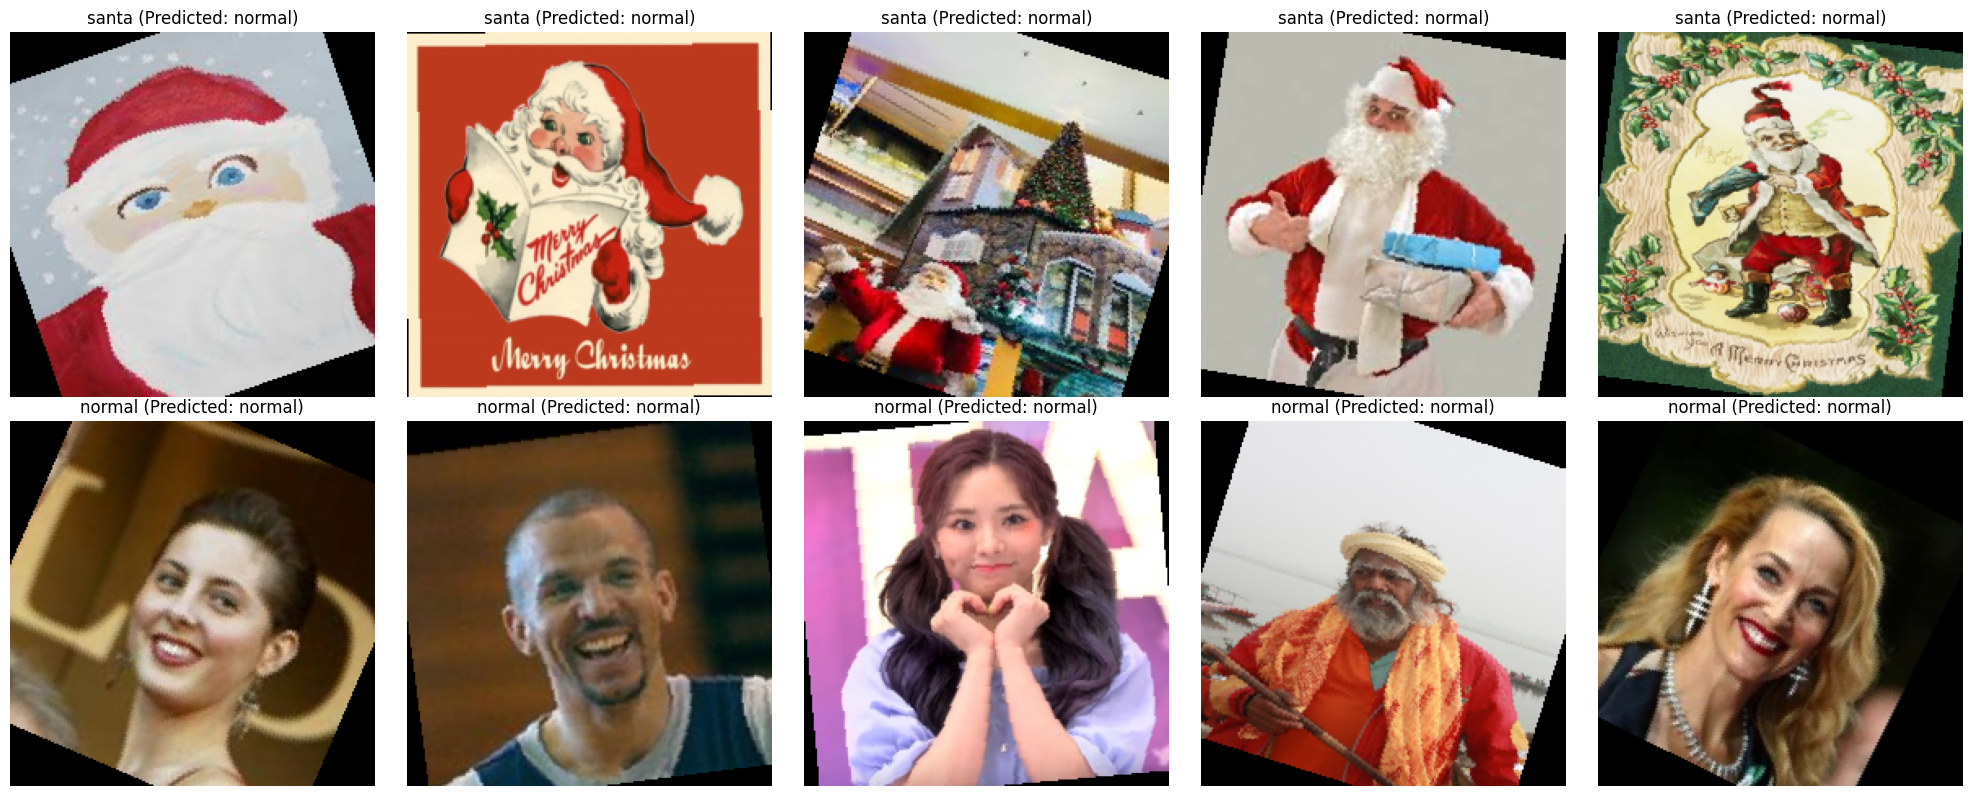

In [117]:
import numpy as np

class_folders = {
    'santa': '../실습 파일/4/test/santa',
    'normal': '../실습 파일/4/test/normal'
}

plt.figure(figsize=(20, 8))

counter = 1

for class_name, folder_path in class_folders.items():
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = np.random.choice(image_paths, size=5, replace=False)
    
    for image_path in selected_paths:
        image = load_and_transform_image(image_path, transform)
        
        net.eval()
        
        with torch.no_grad():
            outputs = net(image)
            _, predicted = torch.max(outputs, 1)
        prediction = 'santa' if predicted.item() == 1 else 'normal'
        
        plt.subplot(2, 5, counter)
        # denormalize 함수를 사용하여 이미지 복원
        display_image = denormalize(image.cpu().squeeze())
        plt.imshow(display_image.permute(1, 2, 0).clamp(0, 1))  # 값을 0~1 범위로 제한
        plt.title(f'{class_name} (Predicted: {prediction})')
        plt.axis('off')
        counter += 1
        

plt.tight_layout()
plt.show()